In [2]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

____
### Más Predicciones

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.model_selection import train_test_split
# from xgboost import plot_importance, plot_tree

from src.common.utils import get_date_for_timestamp_file, get_metrics
from src.features.build_features import add_date_features, assign_unidades_anteriores
from src.visualization.visualize import plot_importance_reg

Intentamos agregar las características de POS a la hora de hacer la predicción y ver si nuestro modelo mejora con respecto a sus métricas.

In [30]:
df_ventas = pd.read_parquet('../data/interim/05-ventas.parquet')
df_pos = pd.read_parquet('../data/interim/02-pos.parquet')

In [5]:
df_ventas_pos = df_ventas.merge(df_pos, on='id_pos')

Realizamos la predicción con todas las columnas y verificamos la importancia que les da el modelo a la hora de dividir

In [52]:
cols_prediction = lambda df: ~df.columns.isin(["unidades","id_pos", "unidades_12", "unidades_13"])

In [53]:
X = df_ventas_pos.loc[:, cols_prediction]

y = df_ventas_pos.loc[:,['unidades']]

In [54]:
# reg = RandomForestRegressor(
#     n_estimators=250,
#     max_depth=8
# )
reg = xgb.XGBRFRegressor(
    n_estimators=250,
    max_depth=8,
    missing=-1,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    eval_metric='mae'
)

In [55]:
%%time
reg.fit(X, y.values.reshape(-1))

XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
               colsample_bytree=1, early_stopping_rounds=50, eval_metric='mae',
               gamma=0, learning_rate=1, max_delta_step=0, max_depth=8,
               min_child_weight=1, missing=-1, n_estimators=250, n_jobs=1,
               nthread=None, objective='reg:squarederror', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=0.8, verbosity=1)

In [56]:
get_metrics(y, np.round(reg.predict(X)))

{'explained_variance_score': 0.7756549287525563,
 'mae': 0.7363705391040243,
 'r2': 0.7756482323979539}

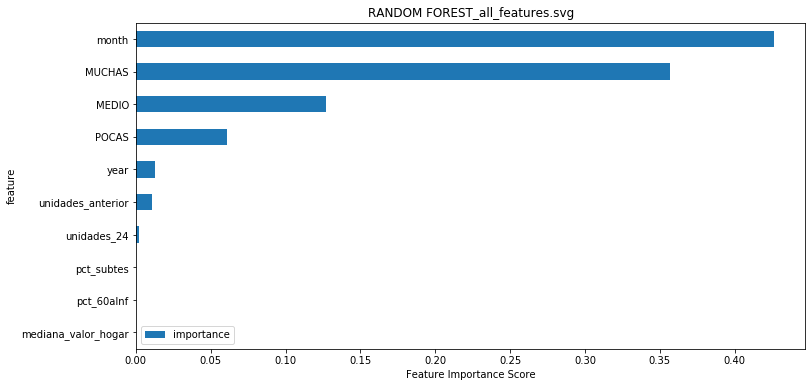

In [57]:
plot_importance_reg(reg, X.columns, "RANDOM FOREST_all_features.svg")

### Verificamos la predicción

In [63]:
dt = get_date_for_timestamp_file()

In [64]:
df_graph = df_ventas[["id_pos", "year", "month"]].copy()
df_graph.loc[:, "unidades"] = y
df_graph.loc[:, "pred"] = np.round(reg.predict(X))

df_graph = df_graph.groupby(["year","month"])[["unidades","pred"]].sum()

In [65]:
X_predict = pd.DataFrame({'id_pos': df_ventas.id_pos.unique()})
X_predict.loc[:,'fecha'] = pd.date_range('12/1/2014', periods=1, freq='M')
add_date_features(X_predict)

X_predict = X_predict.merge(df_pos, on="id_pos")
X_predict.loc[:,"unidades_anterior"] = assign_unidades_anteriores(df_ventas, 2014, 11)
# X_predict.loc[:,"unidades_12"] = assign_unidades_anteriores(df_ventas, 2013, 12)
# X_predict.loc[:,"unidades_13"] = assign_unidades_anteriores(df_ventas, 2013, 11)
X_predict.loc[:,"unidades_24"] = assign_unidades_anteriores(df_ventas, 2012, 12)
X_predict.loc[:,"unidades_25"] = assign_unidades_anteriores(df_ventas, 2012, 11)
X_predict.fillna(-1, inplace=True)
X_predict = X_predict.loc[:, list(X.columns) +["id_pos"]]

In [66]:
X_predict.loc[:,"pred"] = np.round(reg.predict(X_predict.loc[:,~X_predict.columns.isin(["id_pos"])]))

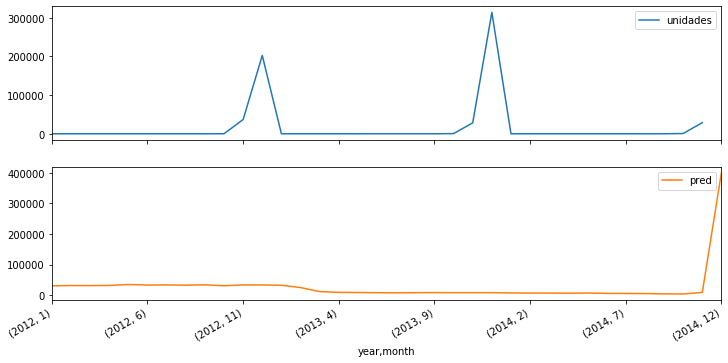

In [67]:
(
    df_graph
    .append(X_predict.groupby(['year','month'])[["pred"]].sum(), sort=False)
    .plot.line(subplots=True, figsize=(12,6))
)

plt.savefig('../reports/figures/06-01-predicción-{}.svg'.format(dt))

Guardamos la respuesta en un archivo

Me quedo con todos los id_pos del archivo de respuestas, ya que algunos no tienen ventas, a ellos le agregó unidades "0". Los mismos, deben encontrarse ordenados igual que el archivo de ejemplo. 

In [68]:
(
    df_pos.reset_index()
    .merge(X_predict, on="id_pos", how="left")
    .fillna(0)[["id_pos","pred"]]
    .astype("int")
    .to_csv('../data/processed/rta-06-{}.csv'.format(dt), index=False, header=False)
)

Seguramente las columnas de tipo_pos_venta (MUCHAS, POCAS, MEDIO) estén directamente relacionadas con la respuesta. Si las quitamos no creemos obtener mejores resultados.
